In [12]:
from __future__ import division
import numpy as np
import scipy.io as scipy
import matplotlib.pyplot as plt
!pip install mne
import mne
from numpy import *
from numpy.fft import *
import scipy.signal as signal
from matplotlib.pyplot import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import sklearn

In [13]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], scipy.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, scipy.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [14]:
p2_all = loadmat('P2_AllLifts.mat')
print( "All Lifts loaded")



#these are the series we are looking at for subject 2. Everything except series 1 and 6
trials_included=[2, 3, 4, 5, 7, 8, 9] 

#corresponding row indices in P.AllLifts where each series starts. Index is off by one bc of how python indexes things
trialStartIdx = [28, 62, 96, 130, 192, 226, 260]

#data structure to hold all EEG trials 
eeg_grasp_closed = []
eeg_grasp_open = []
emg_grasp_closed = []
emg_grasp_open = []
series_counter = 0
trial_counter = 1
i = 0
for s in trials_included:
    # load all the series specified in trials_included
    series_filename = 'WS_P2_S{series}.mat'.format(series = s)
    p_series = loadmat(series_filename)
    print("Series data loaded")
    series_counter = series_counter + 1
    print("series_counter: ", series_counter)

    #identifying the starting row index in p.ALLLifts for the first trial of the current series
    tStart = trialStartIdx[i]
    i += 1
    trial_counter = 1
    #range for the for loop is 34 values bc there are 34 trials in each series
    for trial_num in range(tStart, tStart + 34):
        
        #retrieving the point in time when both fingers touched object
        #index values are one cloumn and one row before target value
        tBothDigitTouch = np.array(p2_all['P']['AllLifts'])[trial_num, 14]
        
        tBothReleased = np.array(p2_all['P']['AllLifts'])[trial_num, 22]
        
        #converting time points to row indices to be accessed in windowed struct
        #500 samples every second, so timepoint should be divided by 0.002
        idxCloseEnd = int(tBothDigitTouch // 0.002) + int(0.8//0.002)
        idxCloseStart = int(tBothDigitTouch // 0.002)- int(0.8//0.002)
        
        idxOpenEnd = int(tBothReleased // 0.002)+ int(0.8//0.002)
        idxOpenStart = int(tBothReleased // 0.002)- int(0.8//0.002)
        
        idxCloseEndEMG = int(tBothDigitTouch // 0.0002) + int(0.8//0.0002)
        idxCloseStartEMG = int(tBothDigitTouch // 0.0002) - int(0.8//0.0002)
        
        idxOpenEndEMG = int(tBothReleased // 0.0002) + int(0.8//0.0002)
        idxOpenStartEMG = int(tBothReleased // 0.0002) - int(0.8//0.0002)

        eeg_trial = np.array(p_series['ws']['win'][0]['eeg'])[idxCloseStart:idxCloseEnd].T 
        eeg_grasp_closed.append(eeg_trial)
        
        eeg_trial = np.array(p_series['ws']['win'][0]['eeg'])[idxOpenStart:idxOpenEnd].T 
        eeg_grasp_open.append(eeg_trial)
        
        emg_trial = np.array(p_series['ws']['win'][0]['emg'])[idxCloseStartEMG:idxCloseEndEMG].T 
        emg_grasp_closed.append(emg_trial)
        
        emg_trial = np.array(p_series['ws']['win'][0]['emg'])[idxOpenStartEMG:idxOpenEndEMG].T 
        emg_grasp_open.append(emg_trial)
        #print("trial counter: ", trial_counter)
        trial_counter = trial_counter +1
                                                            

All Lifts loaded
Series data loaded
series_counter:  1
Series data loaded
series_counter:  2
Series data loaded
series_counter:  3
Series data loaded
series_counter:  4
Series data loaded
series_counter:  5
Series data loaded
series_counter:  6
Series data loaded
series_counter:  7


In [49]:
series = [2, 3, 4, 5, 7, 8, 9]
eeg_close = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(eeg_grasp_closed[s])
    eeg_close[series[i]] = new_list
#print(eeg_close.keys())
#print(eeg_close.values())


In [51]:
series = [2, 3, 4, 5, 7, 8, 9]
eeg_open = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(eeg_grasp_open[s])
    eeg_open[series[i]] = new_list
#print(eeg_open.keys())
#print(eeg_open.values())

In [52]:
series = [2, 3, 4, 5, 7, 8, 9]
emg_close = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(emg_grasp_closed[s])
    emg_close[series[i]] = new_list
#print(emg_close.keys())
#print(emg_close.values())

In [53]:
series = [2, 3, 4, 5, 7, 8, 9]
emg_open = {}
counter = 0
for i in range (0, len(series)):
    new_list  = []
    for s in range(34*(i-1), 34*i):
        new_list.append(emg_grasp_open[s])
    emg_open[series[i]] = new_list
#print(emg_open.keys())
#print(emg_open.values())

In [58]:
test_arr = emg_close[2][0][4]
print(test_arr)


[0.01030871 0.01137871 0.01717871 ... 0.05623871 0.06707871 0.07256871]


In [59]:
def rectify(emg_data): 
    return abs(emg_data)

def removeMean(emg_data): 
    return emg_data - np.mean(emg_data)

def bandpass_filter(emg_data, sfreq, lowband, highband): 
    high_band = highband/(sfreq/2)
    low_band = lowband/(sfreq/2)
    b1, a1 = signal.butter(4, [high_band,low_band], btype='bandpass')
    return signal.filtfilt(b1, a1, emg_data)

def lowpass_filter(emg_data, sfreq, lowpass):
    low_pass = lowpass/(sfreq/2)
    b2, a2 = signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = signal.filtfilt(b2, a2, emg_data)
    return emg_envelope




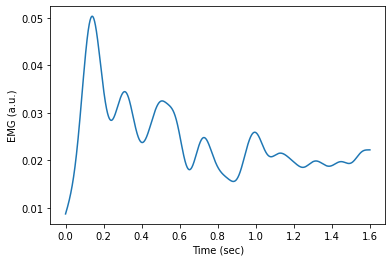

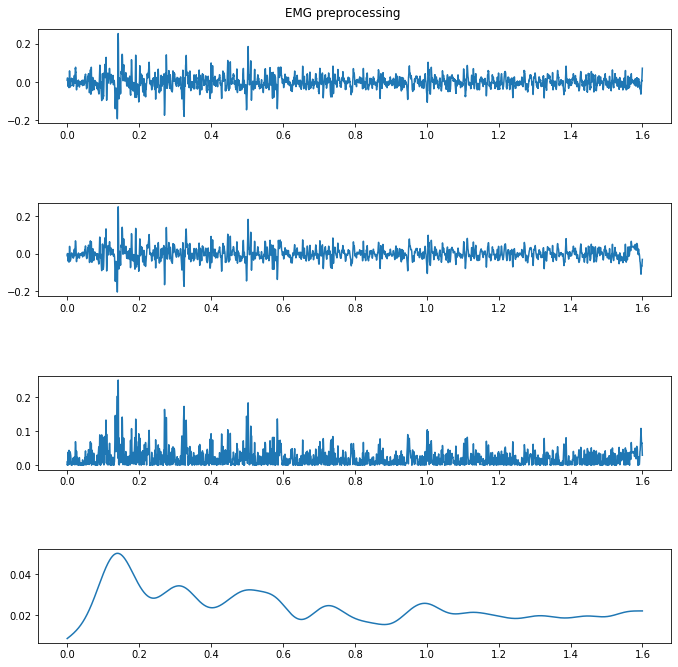

In [60]:
time = np.array([i/5000 for i in range(0, len(test_arr), 1)])

# remove mean
emg_data = removeMean(test_arr)

# bandpass filter
emg_filtered = bandpass_filter(emg_data, 5000, 500, 10)

# rectify data
emg_rectified = rectify(emg_filtered)

# lowpass filter 
emg_envelope = lowpass_filter(emg_rectified, 5000, 7)


# Plotting


plt.plot(time, emg_envelope)
plt.xlabel('Time (sec)')
plt.ylabel('EMG (a.u.)')


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(10)
fig.suptitle('EMG preprocessing')
ax1.plot(time,test_arr)
ax2.plot(time, emg_filtered)
ax3.plot(time, emg_rectified)
ax4.plot(time, emg_envelope)




